# About this model

In this iteration of the project we use a extremely simple cnn to test the waters. The model is the following:

  nn.Conv2d(3, 8, 3, stride=1, padding=1, dilation=1)

  nn.ReLU(True)

  nn.Conv2d(8, 1, 1, stride=1, padding=0, dilation=1)

  nn.sigmoid() (not shown in the code because it is included in the loss)

The loss is binary cross entropy with weights calculated from the dataset. We observed that the negative data outweights the positive data 5 times. Therefore, we compensated the positive weights by this number. 

# Check if GPU is completely free

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
GPU_size = len(GPUs)
print(GPU_size)
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=b830c9f43baad19a162d39be8c9e8f602f69b9c49cd61b10a6826001f50b94ec
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
1
Gen RAM Free: 12.8 GB  | Proc size: 156.4 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


# Kill if it isn't


In [0]:
# !kill -9 -1 # uncomment if you want to use it

# Install Pytorch


In [4]:
# !pip3 install torch torchvision # uncomment if your vm has it not installed

# Link drive to virtual machine

In [5]:
from google.colab import drive
prefix = "/content/drive"
drive.mount("/content/drive", force_remount=True)
# needed accesses to the data and more importantly has added it to his drive under /My Drive/Colab Notebooks/road_segmentation/
prefix = prefix + '/My Drive/Colab Notebooks/road_segmentation/' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Imports

In [0]:
import numpy as np
import h5py
import glob
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Useful functions


In [0]:
def calculate_f1_score(actual, predictions):
    """Example function with PEP 484 type annotations.

    Args:
        param1: The first parameter.
        param2: The second parameter.

    Returns:
        The return value. True for success, False otherwise.

    """
    predictions = predictions > 0
    
    total_predicted_positives = predictions.sum()
    total_actual_positives = actual.sum()
    true_positives = (actual*predictions).sum()
    
    precision = true_positives/total_predicted_positives
    recall = true_positives/total_actual_positives
    
    f1_score = 2 * ( precision * recall )/( precision + recall )
    
    return f1_score
    

In [0]:
def convert_1_to_3_channels(image):
    stacked_img = np.stack((image,)*3, axis=-1)
    return stacked_img    
    

In [21]:
# o = output
# p = padding
# k = kernel_size
# s = stride
# d = dilation
# o = [i + 2*p - k - (k-1)*(d-1)]/s + 1

def get_size_of_padding(output_size, input_size, kernel_size=3, stride=1, dilation=1):
    return (stride*(output_size-1) + kernel_size - input_size + (kernel_size - 1)*(dilation - 1) )/2
output_size = 400
input_size = 400
kernel_size = 3
stride = 1
dilation = 1
print(get_size_of_padding(output_size, input_size, kernel_size, stride, dilation))

1.0


# Paths for data and models

In [0]:
h5_path = prefix + 'data/dataNorm.h5' # we use normalized data
path_to_models = prefix + 'models/simplest'

# Create Database


In [0]:
import torchvision.transforms.functional as TF
class Road_Segmentation_Database(torch.utils.data.Dataset):
    def __init__(self, training):
        super(Road_Segmentation_Database, self).__init__()
        self.hf = h5py.File(h5_path, 'r')    
        self.training = training
        
        if self.training:
            self.sizeTrain = len(self.hf['train'])
        else:
            self.sizeTrain = len(self.hf['test'])
         

    def __getitem__(self, index):
    
        hfFile = self.hf   
        
        if self.training:
            imgX = hfFile['train'][index, ...]
            imgY = hfFile['train_groundtruth'][index, ...]
        else:
            imgX = hfFile['test'][index, ...]
            imgY = hfFile['test_groundtruth'][index, ...]
        
        tensorX = torch.as_tensor(imgX).float()
        tensorY = torch.as_tensor(imgY).float()
        
        if torch.cuda.is_available():
            tensorX = tensorX.cuda()
            tensorY = tensorY.cuda()
        
        return (tensorX, tensorY)
 
    def __len__(self):
        
        return self.sizeTrain 

def load_dataset(training):
    
    dataset = Road_Segmentation_Database(training)

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=8,
        shuffle=True,
        num_workers=0
    )
    return loader



In [0]:
trainloader = load_dataset(training=True)
testloader = load_dataset(training=False)

In [12]:
import torch.nn as nn
import torch.nn.functional as F



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=1, padding=1, dilation=1), 
            nn.ReLU(True),
            
            nn.Conv2d(8, 1, 1, stride=1, padding=0, dilation=1),  

        )

    def forward(self, x):
        x = self.network(x)
        return x
net = Net()
if torch.cuda.is_available():
    print("cuda available")
    net.cuda()


cuda available


In [0]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss(torch.tensor([5]))# nn.BCELoss()

In [0]:
training_f1 = []
validation_f1 = []
trainingLoss = []
validationLoss = []
durations = []
epochSize = 10000
testDataSize = len(testloader)
trainDataSize = len(trainloader)
startAt = 0

In [0]:
# startAt = 0
# modelFolderName = "simple"
# net.load_state_dict(torch.load(path_to_models+'/net_Epoch_#' + str(startAt-1) +'.pt'))
# if torch.cuda.is_available():
#     print("cuda available!")
#     net.cuda()



In [19]:
%%time
import time
start = time.time()

for epoch in range(startAt,epochSize):  # loop over the dataset multiple times

    train_running_loss = 0.0
    test_running_loss = 0.0
    
    train_running_f1 = 0.0
    test_running_f1 = 0.0
    
    
    for i, data in enumerate(trainloader, 0):
        
        if i%10000 == 0:
            print('%d' % int((1000 * (i+epoch*trainDataSize)/(trainDataSize*epochSize))) + '‰ done')
    
        # get the inputs
        inputs, trueImage = data
        
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            trueImage = trueImage.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize

        outputs = net(inputs)
        loss = criterion(outputs, trueImage)
        loss.backward()
        optimizer.step()
        
        # print statistics
        train_running_loss += loss.item()
        train_running_f1 += calculate_f1_score(trueImage[0].squeeze().cpu().numpy(), outputs[0].detach().squeeze().cpu().numpy())
        
   
    # epoch done test on validation
        
    for i, data in enumerate(testloader, 0):
        
         # get the inputs
        inputs, trueImage = data
        
        # cuda them
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            trueImage = trueImage.cuda()

        # forward and test

        outputs = net(inputs)
        loss = criterion(outputs, trueImage)
        
        # print statistics
        test_running_loss += loss.item()
        test_running_f1 += calculate_f1_score(trueImage[0].squeeze().cpu().numpy(), outputs[0].detach().squeeze().cpu().numpy())
    
    # store statistics
    
    trainingLoss.append(train_running_loss/trainDataSize)
    validationLoss.append(test_running_loss/testDataSize)
    
    training_f1.append(train_running_f1/trainDataSize)
    validation_f1.append(test_running_f1/testDataSize)
    
#     print(trainingLoss)
#     print(validationLoss)
    
    if(epoch % 10 == 0):
      print("Current training loss is " + str(train_running_loss/trainDataSize))
      print("Current test loss is " + str(test_running_loss/testDataSize))
      print("Current f1_score for training is " + str(train_running_f1/trainDataSize))
      print("Current f1_score for test is " + str(test_running_f1/testDataSize))
      # save net 
      torch.save(net.state_dict(), path_to_models+'/net_Epoch_#' + str(epoch) +'.pt')
      print("Epoch " + str(epoch))
      end = time.time()
      epochDuration = (end - start)
      durations.append(epochDuration)
      print("Duration of 10 Epoch is " + str(np.mean(durations)/60.0 ) + " minutes")
      print("Estimated " + str(np.mean(durations)/60.0 * (epochSize-epoch+startAt-1)/10.0 ) + " minutes left until completion" )
      print()
      start = end
    
print()
print('Finished Training')
print()


0‰ done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Current training loss is 2.3677829802036285
Current test loss is 2.532847261428833
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 0
Duration of 10 Epoch is 0.07035060540223734 minutes
Estimated 703.4357034169711 minutes left until completion

0‰ done
0‰ done
0‰ done
0‰ done
0‰ done
0‰ done
0‰ done
0‰ done
0‰ done
1‰ done
Current training loss is 2.349477529525757
Current test loss is 2.5309250354766846
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 10
Duration of 10 Epoch is 0.07140585808526902 minutes
Estimated 713.2731164137522 minutes left until completion

1‰ done
1‰ done
1‰ done
1‰ done
1‰ done
1‰ done
1‰ done
1‰ done
1‰ done
2‰ done
Current training loss is 2.342760682106018
Current test loss is 2.529970645904541
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 20
Duration of 10 Epoch is 0.07229851404825846 minutes
Estimated 721.4668716875711 minutes left until completion

2‰ done
2‰ done
2‰ done

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


13‰ done
13‰ done
14‰ done
Current training loss is 2.3167962431907654
Current test loss is 2.5236305236816405
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 140
Duration of 10 Epoch is 0.08167855945634253 minutes
Estimated 805.268917680081 minutes left until completion

14‰ done
14‰ done
14‰ done
14‰ done
14‰ done
14‰ done
14‰ done
14‰ done
14‰ done
15‰ done
Current training loss is 2.328139752149582
Current test loss is 2.5225374698638916
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 150
Duration of 10 Epoch is 0.08207780193714868 minutes
Estimated 808.3842712789774 minutes left until completion

15‰ done
15‰ done
15‰ done
15‰ done
15‰ done
15‰ done
15‰ done
15‰ done
15‰ done
16‰ done
Current training loss is 2.316292643547058
Current test loss is 2.5213155269622805
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 160
Duration of 10 Epoch is 0.08245384460208059 minutes
Estimated 811.263377039871 min

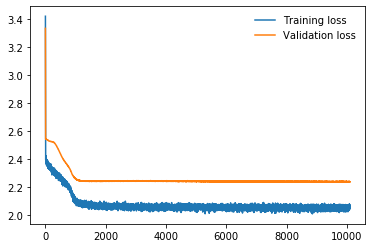

In [22]:
plt.plot(trainingLoss[:], label='Training loss')
plt.plot(validationLoss[:], label='Validation loss')
plt.legend(frameon=False)
plt.show()

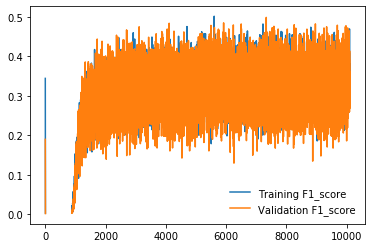

In [23]:
plt.plot(training_f1[:], label='Training F1_score')
plt.plot(validation_f1[:], label='Validation F1_score')
plt.legend(frameon=False)
plt.show()

# Analyse results

cuda available!
[[[-2.0110703  -1.0823344  -1.2544135  ... -1.209895   -1.2719857
   -1.2746567 ]
  [-1.5240153  -0.20025706 -0.17004967 ... -0.89667976 -1.0118533
   -0.9141122 ]
  [-1.6672379  -0.8744787  -0.72010696 ... -1.2019397  -1.1779548
   -0.9121269 ]
  ...
  [-5.147996   -6.957635   -5.940744   ... -0.8741003  -1.0160512
   -0.3372363 ]
  [-5.2996025  -7.559846   -5.931019   ...  0.24016201  0.1476202
   -0.46648633]
  [-4.406233   -6.1061087  -4.839538   ... -1.3340772  -1.4017354
   -1.8021637 ]]]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ... 255 255   0]
 [  0   0   0 ...   0   0   0]]


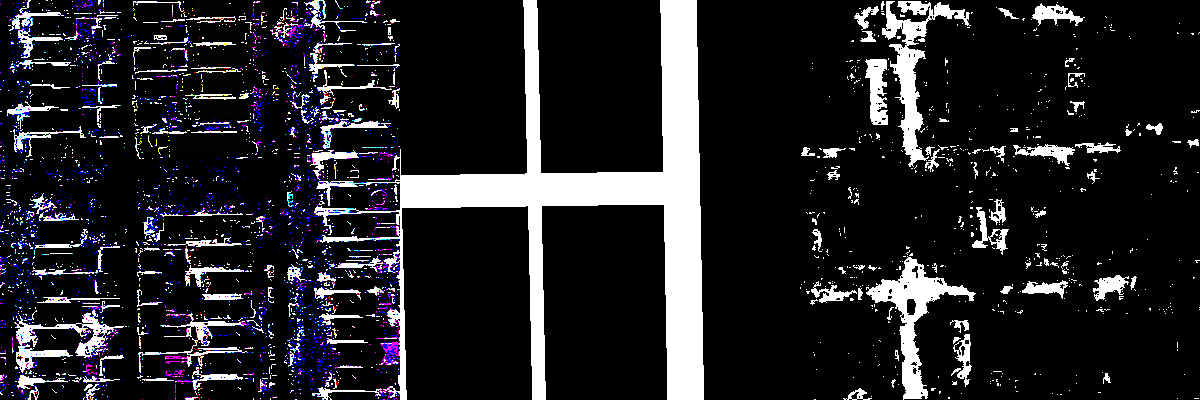

In [28]:
wantedNet = 9990
net.load_state_dict(torch.load(path_to_models+'/net_Epoch_#' + str(wantedNet) +'.pt'))
if torch.cuda.is_available():
    print("cuda available!")
    net.cuda()
images, groundtruth = next(iter(testloader)) 
outputs = net(inputs)

image = images[0].cpu().numpy()
groundtruth = groundtruth[0].cpu().numpy()
print(outputs[0].detach().cpu().numpy())
net_result = outputs[0].detach().cpu().numpy()
net_result = net_result > 0
image = np.moveaxis(image, 0, 2)
groundtruth = np.moveaxis(groundtruth, 0, 2)
net_result = np.moveaxis(net_result, 0, 2)

image = image.astype("uint8")
groundtruth = groundtruth.astype("uint8")
net_result = net_result.astype("uint8")

groundtruth = groundtruth.reshape((400,400))*255
net_result = net_result.reshape((400,400))*255
print(net_result)

groundtruth = convert_1_to_3_channels(groundtruth)
net_result = convert_1_to_3_channels(net_result)

compare = np.hstack([image, groundtruth, net_result])

compare = Image.fromarray(compare)

compare

